In [1]:
from itertools import combinations
from math import factorial
from typing import Tuple
import seaborn as sns
import math
from tqdm.auto import tqdm

import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import linregress
%load_ext autoreload
%autoreload 2

# Theoretical Exemple Scalar Mean

In [12]:
N = 100
num_samples = np.random.randint(100, 1000, size=N)
MU = 50
SIGMA = 2
mus = np.random.normal(MU, SIGMA, size=N)
sigmas = np.random.random(size=N) * 2 + 2

V = np.eye(N) * sigmas
C = mus.reshape((N, 1)) @ mus.reshape(N, 1).T
W = C @ np.linalg.inv(C + V)

C = (W.T - W).sum(axis=0)
C_bis = C - np.min(C)
C_bis = C_bis / np.max(C_bis)

utility = lambda x: 10 / (1 + x)
local_mse = sigmas ** 2 / num_samples
mtl_mse = mus ** 2 / (1 + (mus ** 2 / local_mse).sum())
gains = utility(mtl_mse) - utility(local_mse)

In [3]:
E_cache = {}
u_E_cache = {}
fac_cache = {}

def val(indices: Tuple, idx: int) -> float:
    np_indices = np.array(list(indices))
    if indices in E_cache:
        E = E_cache[indices]
    else:
        E = (mus[np_indices] ** 2 * num_samples[np_indices] / sigmas[np_indices] ** 2).sum()
        E_cache[indices] = E
        
    if indices in u_E_cache:
        u_E = u_E_cache[indices]
    else:
        u_E = (utility(mus[np_indices] ** 2 / (1 + E))).sum()
        u_E_cache[indices] = u_E
    
    indices_i = indices + (idx, )
    if indices_i in E_cache:
        E_i = E_cache[indices_i]
    else:
        E_i = E + (mus[idx] ** 2 * num_samples[idx] / sigmas[idx] ** 2)
        E_cache[indices_i] = E_i
        
    if len(np_indices) == 1:
        return (utility(mus[np_indices] ** 2 / (1 + E_i))).sum() - utility(
            (sigmas[np_indices] ** 2 / num_samples[np_indices]).item())
    else:
        return (utility(mus[np_indices] ** 2 / (1 + E_i))).sum() - u_E

def factorial_sp(n: int) -> int:
    if n in fac_cache:
        return fac_cache[n]
    else:
        val = factorial(n)
        fac_cache[n] = val
        return val

def shapley_value(idx: int):
    res = 0
    for i in range(1, N - 1):
        pbar.set_description(f'{idx}: {i}', refresh=True)
        for comb in combinations([j for j in range(N) if j != idx], i):
            res += factorial_sp(len(comb)) * factorial_sp(N - len(comb) - 1) * val(comb, idx)
            pbar.update(1)
    return res / factorial(N)

total_iterations = N * sum([math.comb(N - 1, i) for i in range(1, N - 1)])
pbar = tqdm(total=total_iterations, desc='Overall Progress')

shap_val = list(map(lambda x: shapley_value(x), range(N)))

pbar.close()

Overall Progress:   0%|          | 0/63382530011411470074835160268600 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
C_plot, shap_plot = [], []
iter = 10
N = 20
total_iterations = N * sum([math.comb(N - 1, i) for i in range(1, N - 1)]) * iter
pbar = tqdm(total=total_iterations, desc='Overall Progress')
for _ in range(iter):
    E_cache = {}
    u_E_cache = {}
    
    num_samples = np.random.randint(100, 1000, size=N)
    MU = 50
    SIGMA = 2
    mus = np.random.normal(MU, SIGMA, size=N)
    sigmas = np.random.random(size=N) * 2 + 2
    
    V = np.eye(N) * sigmas
    C = mus.reshape((N, 1)) @ mus.reshape(N, 1).T
    W = C @ np.linalg.inv(C + V)
    
    C = (W.T - W).sum(axis=0)
    C_bis = C - np.min(C)
    C_bis = C_bis / np.max(C_bis)
    C_plot.extend(C_bis)
    
    shap_val = list(map(lambda x: shapley_value(x), range(N)))
    shap_plot.extend(shap_val)

Overall Progress:   0%|          | 0/104857200 [00:00<?, ?it/s]

In [8]:
gains.shape, local_mse.shape, mtl_mse.shape, C.shape, C_bis.shape, W.shape

((20,), (20,), (20,), (20,), (20,), (20, 20))

In [ ]:
x, y = 1 - C_plot, shap_plot
#for i in range(iter):
    #sns.scatterplot(x=x[i * N : (i + 1) * N], y=y[i * N : (i + 1) * N])

sns.scatterplot(x=x, y=y)

# Fit linear regression line
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Plot the regression line
plt.plot(x, slope * np.array(x) + intercept, color='red')
plt.title(f'Trust matrix based contribution vs Shapley value')
plt.xlabel('Normalized contribution vector')
plt.ylabel('Shapley value')

print("Slope:", slope)
print("Intercept:", intercept)

# Show plot
plt.show()

Slope: -0.007947425180755568
Intercept: 0.05166511614191897


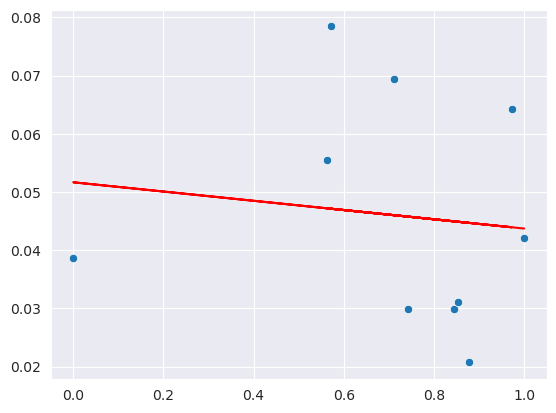

In [19]:
x, y = 1 - C_bis, shap_val
sns.scatterplot(x=x, y=y)

# Fit linear regression line
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Plot the regression line
plt.plot(x, slope * np.array(x) + intercept, color='red')

print("Slope:", slope)
print("Intercept:", intercept)

# Show plot
plt.show()

Slope: 9.272029644314756
Intercept: 0.00736848209078006


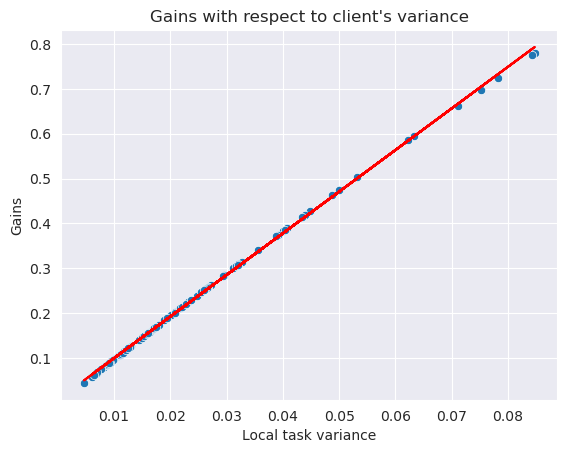

In [58]:
x, y = local_mse, gains
sns.scatterplot(x=x, y=y)

# Fit linear regression line
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Plot the regression line
plt.plot(x, slope * np.array(x) + intercept, color='red')
plt.title(f"Gains with respect to client's variance")
plt.xlabel('Local task variance')
plt.ylabel('Gains')



print("Slope:", slope)
print("Intercept:", intercept)

# Show plot
plt.show()

Slope: -0.34793397493507006
Intercept: 0.38673674746116393


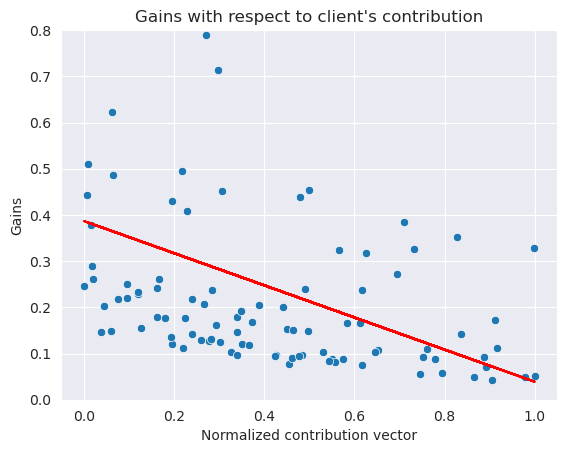

In [13]:
x, y = 1 - C_bis, gains
sns.scatterplot(x=x, y=y)

# Fit linear regression line
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Plot the regression line
plt.plot(x, slope * np.array(x) + intercept, color='red')
plt.title(f'Gains with respect to client\'s contribution')
plt.xlabel('Normalized contribution vector')
plt.ylabel('Gains')
plt.ylim((0, 0.8))

print("Slope:", slope)
print("Intercept:", intercept)

# Show plot
plt.show()

## With C regularizer

In [14]:
mtl_mse = mus ** 2 / (1 + (mus ** 2 / local_mse).sum()) + C_bis * local_mse
gains_C_reg = utility(mtl_mse) - utility(local_mse)

Slope: 0.11675524248170344
Intercept: 0.02349015994287071


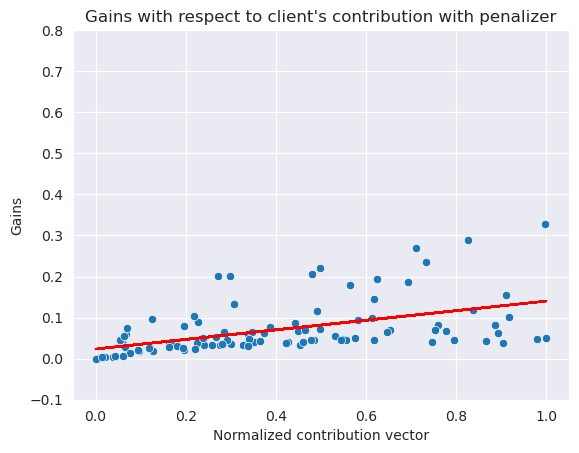

In [18]:
cost = 2e-2
x, y = 1 - C_bis, gains_C_reg
sns.scatterplot(x=x, y=y)

# Fit linear regression line
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Plot the regression line
plt.plot(x, slope * np.array(x) + intercept, color='red')
plt.title(f'Gains with respect to client\'s contribution with penalizer')
#plt.title(f'Gains with respect to client\'s contribution with cost {cost}')
plt.xlabel('Normalized contribution vector')
plt.ylabel('Gains')
plt.ylim((-0.1, 0.8))


print("Slope:", slope)
print("Intercept:", intercept)

plt.show()

Slope: 0.3228955750901943
Intercept: -0.03533434754868392


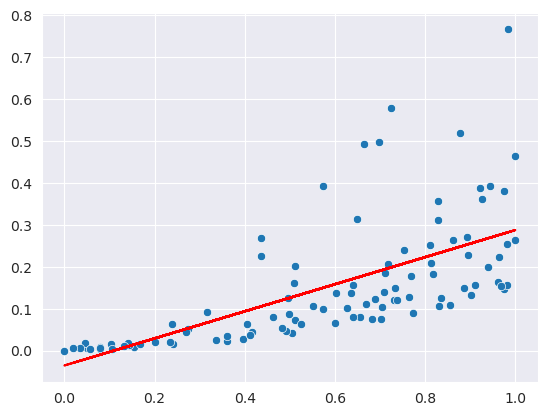

In [76]:
x, y = C_bis, np.abs(gains - gains_C_reg)
sns.scatterplot(x=x, y=y)

# Fit linear regression line
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Plot the regression line
plt.plot(x, slope * np.array(x) + intercept, color='red')

print("Slope:", slope)
print("Intercept:", intercept)

# Show plot
plt.show()

Slope: 1.962855660216378
Intercept: 0.029963925187061313


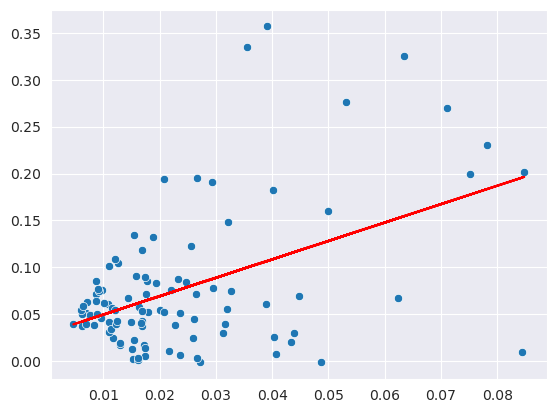

In [77]:
x, y = local_mse, gains_C_reg
sns.scatterplot(x=x, y=y)

# Fit linear regression line
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Plot the regression line
plt.plot(x, slope * np.array(x) + intercept, color='red')

print("Slope:", slope)
print("Intercept:", intercept)

# Show plot
plt.show()